Edward与PyMC3我都已经无力吐槽了，哎，随便吧。差不多就行

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import tensorflow as tf

In [2]:
import pickle
with open('cache_dict_float32','rb') as f:
    cache_dict_float32 = pickle.load(f)
    
stage_list = cache_dict_float32['stage_list_float32']
time_length_list = cache_dict_float32['time_length_list']
latent_scen_4_meansd = cache_dict_float32['latent_scen_4_meansd']

stage_list[0].dtype

dtype('float32')

In [3]:
stage = stage_list[0] 
stage.shape # stage 1 obs


(202, 4, 193)

In [4]:
meansd = np.array(latent_scen_4_meansd[0],dtype='float32') # stage 1 
time_length = np.array(time_length_list[0],dtype='float32') # stage 1

meansd.shape,time_length.shape

((5, 5, 2), (4, 2))

In [5]:
period_num = meansd.shape[0] # in stage 1 -> 5
var_num = meansd.shape[1] # always 5
durations_num = time_length.shape[0] # in stage 1 -> 4
assert time_length.shape[0] == period_num - 1
replay_num = stage.shape[0] # obs

period_num,var_num,durations_num,replay_num

(5, 5, 4, 202)

In [6]:
emu = np.array([stage[:,0,:80].mean(),stage[:,0,80:131].mean(),stage[:,0,131:].mean()],dtype='float32')
esd = np.array([stage[:,0,:80].std(),stage[:,0,80:131].std(),stage[:,0,131:].std()],dtype='float32')

emu

array([ 21.84028435,  40.84634018,   5.01133823], dtype=float32)

In [7]:
%%time
import edward as ed
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture,Empirical

Wall time: 32.5 s


In [16]:
# priori model test

sess = ed.get_session()
tf.global_variables_initializer().run()

In [8]:
stage_length = stage.shape[2]
time_axis = np.arange(stage_length, dtype='float32')

突然发现Gibbs抽样是可以放proposal_vars的，只是不放的会用ed.complete_conditional去算，这个例子真是误导人。。
果然用了Gibbs以后就不会像MetropolisHastings那样乱跑了。看来还有那么点成功的希望。

先实现这个在PyMC3不断秘制失败的模型

```
%%time
with pm.Model() as model:
    # 这里设定stage 1 里5个阶段对应的前4个阶段的持续时间，然后定义断点为持续时间的函数
    # 虽然这个变量不应该是伪随机变量或随机参数，而是隐变量，所以每个replay应该对应一个向量实现，这是第一次用上replay数量信息（之前就搞错了。。）
    durations = Normal('durations', mu = np.array([80,131],dtype='float32'), sd = np.array([3,10],dtype='float32'), shape = 2)
    breaks = tt.cumsum(durations) # length 2 array
    Deterministic('breaks', breaks)
    
    #直接定义三阶段使用参数的分布为半正态分布， 半正态分布标准差当然是sd，均值是sd*sqrt(2/pi)，所以用均值确定sd要*(pi/2)
    mus = pm.HalfNormal('mus', sd = sds, shape=3)
    
    #用向量法硬编码。。我真是要吐血了，真不应该我不熟悉的技术
    
    index_mus = where(time_axis < breaks[0], mus[0], where(time_axis < breaks[1], mus[1], mus[2]))
    #pressing_shift = Poisson('shift', mu=index_mus, observed = stage[0,0,:], shape = stage.shape[2])
    #pressing_shift = Normal('shift', mu=index_mus, sd=index_mus, observed = stage[0,0,:], shape = stage.shape[2])
    pressing_shift = Normal('shift', mu=index_mus, sd=index_mus, observed = stage[0,0,:])

    trace = pm.sample(1000,init=None)
```

In [73]:
# MODEL
durations = ed.models.Normal(loc = [80.0,51.0], scale=[3.0,10.0])

In [74]:
breaks = tf.cumsum(durations)

In [75]:
mus = ed.models.Exponential(rate=1/emu)

In [76]:
index_mus = tf.where(time_axis < breaks[0], tf.tile([mus[0]], [stage_length]), 
                     tf.where(time_axis < breaks[1], tf.tile([mus[1]], [stage_length]), tf.tile([mus[2]], [stage_length])))


In [77]:
pressing_shift = ed.models.Poisson(rate=index_mus)

In [85]:
pressing_shift.eval()

array([  11.,   20.,   24.,   14.,   22.,   14.,   13.,   16.,   16.,
         11.,   13.,   10.,   15.,   15.,   15.,   16.,   25.,    7.,
         12.,   16.,   19.,   19.,   13.,   20.,   19.,   12.,   23.,
         29.,   18.,   13.,   18.,   16.,   13.,   14.,   15.,   10.,
         19.,   19.,   13.,   13.,   17.,   15.,   19.,   16.,   11.,
         13.,   17.,   20.,   17.,   25.,   21.,   11.,   16.,   14.,
         12.,   13.,   15.,   18.,   13.,   14.,   14.,   16.,   14.,
         18.,   23.,   17.,   17.,   15.,   20.,   18.,   21.,   14.,
         19.,   14.,   14.,   17.,   28.,   14.,   10.,    8.,   13.,
         14.,   22.,  117.,  125.,  129.,  139.,  155.,  120.,  116.,
        133.,  151.,  120.,  145.,  153.,  132.,  129.,  140.,  122.,
        150.,  154.,  128.,  142.,  122.,  126.,  148.,  113.,  142.,
        144.,  138.,  129.,  139.,  142.,  129.,  137.,  119.,  140.,
        163.,  134.,  137.,  140.,  129.,  127.,  138.,  128.,  142.,
        152.,  121.,

In [177]:
# Inference
T = 120000

idurations = np.ones([T,2],dtype='float32')
idurations[0,:] = np.array([80.0,51.0],dtype='float32')
imus = np.ones([T,3],dtype='float32')
imus[0,:] = 1/emu

qdurations = ed.models.Empirical(tf.Variable(idurations))
qmus = ed.models.Empirical(tf.Variable(imus))

# proposal variable

gdurations = ed.models.Normal(loc = durations, scale = [0.1,0.1])
gmus = ed.models.Normal(loc = mus, scale = [0.01,0.01,0.01])

In [178]:
inference = ed.MetropolisHastings({durations: qdurations, mus: qmus},
                      proposal_vars = {durations: gdurations, mus: gmus},
                      data = {pressing_shift: stage[0,0,:]})

In [179]:
inference.run()

120000/120000 [100%] ██████████████████████████████ Elapsed: 63s | Acceptance Rate: 0.533


In [180]:
qdurations.params.eval()

array([[ 79.90992737,  51.08301926],
       [ 79.90992737,  51.08301926],
       [ 80.09360504,  51.15585709],
       ..., 
       [ 82.36680603,  48.87617874],
       [ 82.36680603,  48.87617874],
       [ 82.23513031,  48.84752655]], dtype=float32)

In [181]:
qmus.params.eval()

array([[  6.35884330e-02,   2.54823975e-02,   1.97661847e-01],
       [  6.35884330e-02,   2.54823975e-02,   1.97661847e-01],
       [  4.49153483e-02,   3.43182683e-02,   2.04993427e-01],
       ..., 
       [  2.37073898e+01,   5.29967880e+01,   6.99419901e-03],
       [  2.37073898e+01,   5.29967880e+01,   6.99419901e-03],
       [  2.36992264e+01,   5.30212936e+01,   1.12702250e-02]], dtype=float32)

用那个MetropolisHastings例子测试后感觉Gibbs如果带了proposal而不是用它自己那个的话的实现是不是有bug...
好像Acceptance Rate总是为1，结果反而在乱游走。

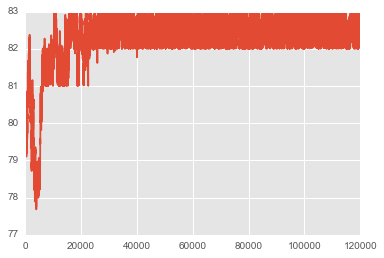

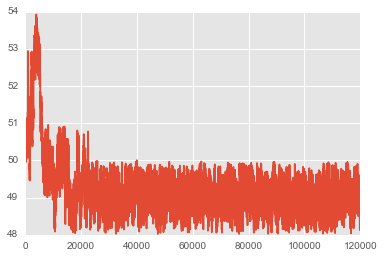

In [182]:
trace = qdurations.params.eval()
plt.plot(trace[:,0])
plt.show()
plt.plot(trace[:,1])
plt.show()

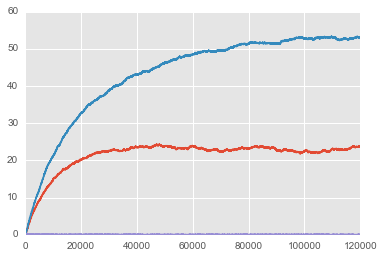

In [183]:
trace = qmus.params.eval()
plt.plot(trace[:,0])
#plt.show()
plt.plot(trace[:,1])
plt.plot(trace[:,2])
plt.show()

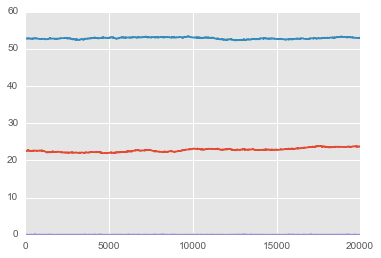

In [184]:
trace = qmus.params.eval()[100000:]
plt.plot(trace[:,0])
#plt.show()
plt.plot(trace[:,1])
plt.plot(trace[:,2])
plt.show()

居然成功了。。。感动，不过有PyMC3那个坑爹的经验我也不敢一次建构太大的模型。一步一步上升吧。接下来我们仍然建立单属性的模型，
但用上全部202个replay。

In [9]:
_time_axis = np.tile(time_axis,(202, 2, 1)) # add batch...
_time_axis.shape

(202, 2, 193)

In [10]:
# MODEL
durations = ed.models.Normal(loc = [80.0,51.0], scale=[3.0,10.0], sample_shape=replay_num) # 202 * 2 matrix

In [11]:
breaks = tf.cumsum(durations, axis=1) # 202 * 2 matrix

这步稍微激进一点，直接用那个坑爹的矩阵技巧，不用那个手动嵌套where

In [12]:
_breaks = tf.transpose(tf.reshape(tf.tile(breaks,(stage_length, 1)),(stage_length,replay_num,2)),(1,2,0))  
# tensorflow的tile比numpy的能力要差一些，要配合reshape处理，另外注意转置的三元组与pymc3的不一样
_breaks

<tf.Tensor 'transpose:0' shape=(202, 2, 193) dtype=float32>

In [13]:
_mask = tf.where(_time_axis > _breaks, tf.ones((replay_num,2,stage_length),dtype=tf.int32), tf.zeros((replay_num,2,stage_length),dtype=tf.int32))

In [14]:
index = tf.reduce_sum(_mask, axis=1)

In [17]:
index.eval()

array([[0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       ..., 
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2]])

In [18]:
mu = ed.models.Exponential(rate = 1/emu)

In [19]:
mu.eval() # 注意这里虽然先验是倒数，但是testval，或者说经验函数第一项取得就是原数不是倒数了

array([ 15.73148251,  27.37333488,   1.63639081], dtype=float32)

In [21]:
index[0].eval()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2])

In [22]:
time_mu_list = []
for i in range(202):
    time_mu_list.append(tf.gather(mu,index[i])) # numpy theano和tensorflow的列表取值行为不一样。。之前的在这里只能用gather实现
time_mu = tf.stack(time_mu_list) # 202 * 193 matrix
time_mu

<tf.Tensor 'stack:0' shape=(202, 193) dtype=float32>

In [23]:
pressing_shift = ed.models.Poisson(rate = time_mu)
pressing_shift

<ed.RandomVariable 'Poisson_2/' shape=(202, 193) dtype=float32>

In [38]:
# Inference
# 到目前为止感觉Edward比PyMC3强，只是MCMC这些废话要自己写也太烦了。。当然自己控制也有自己控制的好处
# 另外前面估计duration是合理的，我们只是知道它的先验分布，但现在我们在求它的后验分布。在给定可观测变量以固定数据的条件下

# Inference
T = 30000

idurations = np.ones([T,replay_num,2],dtype='float32')
idurations[0,:,:] = np.array([80.0,51.0],dtype='float32')
imu = np.ones([T,3],dtype='float32')
imu[0,:] = 1/emu

qdurations = ed.models.Empirical(tf.Variable(idurations))
qmu = ed.models.Empirical(tf.Variable(imu))

# proposal variable

gdurations = ed.models.Normal(loc = durations, scale = np.tile([0.1,0.1],[replay_num,1]).astype('float32'))
gmu = ed.models.Normal(loc = mu, scale = [0.01,0.01,0.01])

In [39]:
inference = ed.MetropolisHastings({durations: qdurations, mu: qmu},
                      proposal_vars = {durations: gdurations, mu: gmu},
                      data = {pressing_shift: stage[:,0,:]})

In [40]:
inference.run()

30000/30000 [100%] ██████████████████████████████ Elapsed: 247s | Acceptance Rate: 0.149


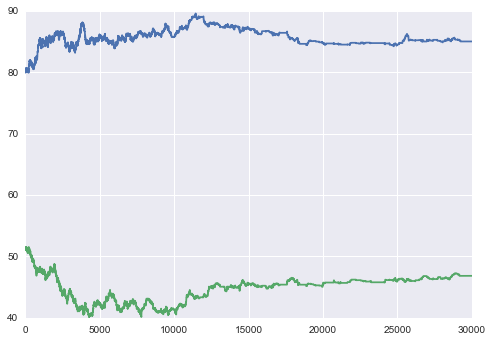

In [41]:
plt.plot(qdurations.params.eval()[:,0])

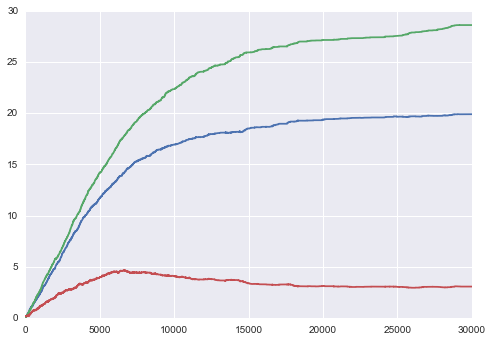

In [42]:
trace = qmu.params.eval()
plt.plot(trace[:,0])
#plt.show()
plt.plot(trace[:,1])
plt.plot(trace[:,2])
plt.show()

出现了和那个例子里的Gibbs采样正好相反的事，不过好歹我能看看到接受率了。。因为接受率太低根本没有发生任何游走。

(/|\我还是naive，看来MH采样在参数离高似然参数相差甚远的时候比较有效，虽然最开始接受率是0，而这时候Gibbs就日了狗了。看看下面那是什么结果。
不过要一开始就在高似然区域，Gibbs倒好像表现还行，在MH根本不动的时候（也许只是proposal分布方差太大而給的初始又太好，
导致接受率太高根本动不起来）

In [31]:
inference = ed.Gibbs({durations: qdurations, mu: qmu},
                      proposal_vars = {durations: gdurations, mu: gmu},
                      data = {pressing_shift: stage[:,0,:]})

In [32]:
inference.run()

30000/30000 [100%] ██████████████████████████████ Elapsed: 31s | Acceptance Rate: 1.000


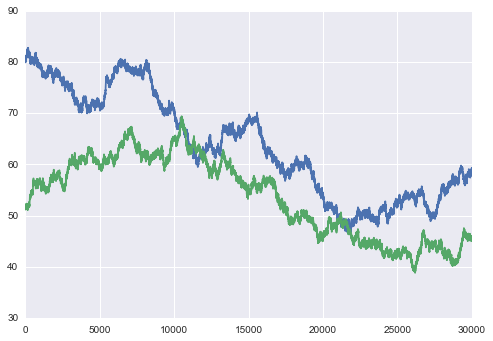

In [36]:
plt.plot(qdurations.params.eval()[:,0])

这接受率尼玛一直是1根本是在随机游走吧。。不过好像那个完美还原结果的二维高斯也是接受率一直是1.。。难道是这个指标的显示本身是错的？

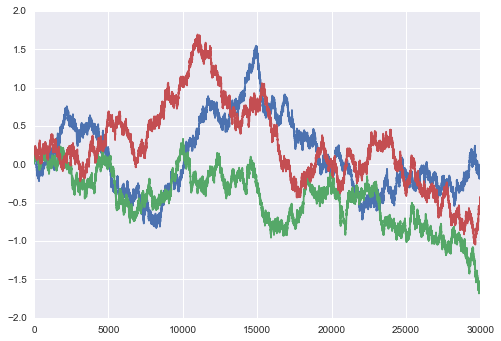

In [35]:
trace = qmu.params.eval()
plt.plot(trace[:,0])
#plt.show()
plt.plot(trace[:,1])
plt.plot(trace[:,2])
plt.show()

既然如此，说明那个矩阵技巧本身没有引发错误，那么我们就可以实现我们的雄心了，还原stage 1 全四变量模型。

In [ ]:
_time_axis = np.tile(time_axis,(202, 2, 1)) # add batch...
_time_axis.shape

In [43]:
# MODEL
# 开始的和时间有关的部分都是一样的
durations = ed.models.Normal(loc = [80.0,51.0], scale=[3.0,10.0], sample_shape=replay_num) # 202 * 2 matrix
breaks = tf.cumsum(durations, axis=1) # 202 * 2 matrix
_breaks = tf.transpose(tf.reshape(tf.tile(breaks,(stage_length, 1)),(stage_length,replay_num,2)),(1,2,0))  
_mask = tf.where(_time_axis > _breaks, tf.ones((replay_num,2,stage_length),dtype=tf.int32), tf.zeros((replay_num,2,stage_length),dtype=tf.int32))
index = tf.reduce_sum(_mask, axis=1)

In [45]:
# 几个参数就不一样了

_shift_mu = np.array([stage[:,0,:80].mean(),stage[:,0,80:131].mean(),stage[:,0,131:].mean()],dtype='float32')
_ctrl_mu  = np.array([stage[:,1,:80].mean(),stage[:,1,80:131].mean(),stage[:,1,131:].mean()],dtype='float32')
_x_mu     = np.array([stage[:,2,:80].mean(),stage[:,2,80:131].mean(),stage[:,2,131:].mean()],dtype='float32')
_move_mu  = np.array([stage[:,3,:80].mean(),stage[:,3,80:131].mean(),stage[:,3,131:].mean()],dtype='float32')
_move_sd  = np.array([stage[:,3,:80].std(), stage[:,3,80:131].std(), stage[:,3,131:].std() ],dtype='float32')

shift_mu = ed.models.Exponential(rate = 1/_shift_mu)
ctrl_mu = ed.models.Exponential(rate = 1/_ctrl_mu)
x_mu = ed.models.Exponential(rate = 1/_x_mu)
move_mu = ed.models.Exponential(rate = 1/_move_mu) # 虽然这里也可以不是指数分布。。但反正它肯定是正的。。
move_sd = ed.models.Exponential(rate = 1/_move_sd) # 虽然这里也可以不是指数分布。。但反正它肯定是正的。。


In [46]:
def share_params_into_period(var, index):
    var_list = []
    for i in range(replay_num):
        var_list.append(tf.gather(var,index[i]))
    var_along_replay = tf.stack(var_list)
    return var_along_replay

In [48]:
shift_mu_time = share_params_into_period(shift_mu, index)
ctrl_mu_time = share_params_into_period(ctrl_mu, index)
x_mu_time = share_params_into_period(x_mu, index)
move_mu_time = share_params_into_period(move_mu, index)
move_sd_time = share_params_into_period(move_sd, index)

In [49]:
pressing_shift = ed.models.Poisson(rate = shift_mu_time)
pressing_ctrl = ed.models.Poisson(rate = ctrl_mu_time)
pressing_x = ed.models.Poisson(rate = x_mu_time)
move = ed.models.Normal(loc = shift_mu_time, scale = move_sd_time)


In [50]:
move

<ed.RandomVariable 'Normal_26/' shape=(202, 193) dtype=float32>

In [51]:
# Inference

# Inference
T = 30000

idurations = np.ones([T,replay_num,2],dtype='float32')
idurations[0,:,:] = np.array([80.0,51.0],dtype='float32')
qdurations = ed.models.Empirical(tf.Variable(idurations))

# 神他妈一堆样板代码，不过没精力想怎么重构了
ishift_mu = np.ones([T,3],dtype='float32')
ishift_mu[0,:] = _shift_mu
qshift_mu = ed.models.Empirical(tf.Variable(ishift_mu))

ictrl_mu = np.ones([T,3],dtype='float32')
ictrl_mu[0,:] = _ctrl_mu
qctrl_mu = ed.models.Empirical(tf.Variable(ictrl_mu))

ix_mu = np.ones([T,3],dtype='float32')
ix_mu[0,:] = _x_mu
qx_mu = ed.models.Empirical(tf.Variable(ix_mu))

imove_mu = np.ones([T,3],dtype='float32')
imove_mu[0,:] = _move_mu
qmove_mu = ed.models.Empirical(tf.Variable(imove_mu))

imove_sd = np.ones([T,3],dtype='float32')
imove_sd[0,:] = _move_sd
qmove_sd = ed.models.Empirical(tf.Variable(imove_sd))


# proposal variable

gdurations = ed.models.Normal(loc = durations, scale = np.tile([0.1,0.1],[replay_num,1]).astype('float32'))

gshift_mu = ed.models.Normal(loc = shift_mu, scale = [0.01,0.01,0.01])
gctrl_mu = ed.models.Normal(loc = ctrl_mu, scale = [0.01,0.01,0.01])
gx_mu = ed.models.Normal(loc = x_mu, scale = [0.01,0.01,0.01])
gmove_mu = ed.models.Normal(loc = move_mu, scale = [0.01,0.01,0.01])
gmove_sd = ed.models.Normal(loc = move_sd, scale = [0.01,0.01,0.01])


In [52]:
inference = ed.MetropolisHastings({durations: qdurations, 
                                   shift_mu: qshift_mu, ctrl_mu: qctrl_mu, x_mu: qx_mu,move_mu: qmove_mu,move_sd: qmove_sd},
                      proposal_vars = {durations: gdurations, 
                                       shift_mu: gshift_mu, ctrl_mu: gctrl_mu, x_mu: gx_mu,move_mu: gmove_mu,move_sd: gmove_sd},
                      data = {pressing_shift: stage[:,0,:], pressing_ctrl: stage[:,1,:], pressing_x: stage[:,2,:], move: stage[:,3,:]})

In [53]:
inference.run()

30000/30000 [100%] ██████████████████████████████ Elapsed: 3710s | Acceptance Rate: 0.007


In [60]:
qshift_mu.params.eval().shape

(30000, 3)

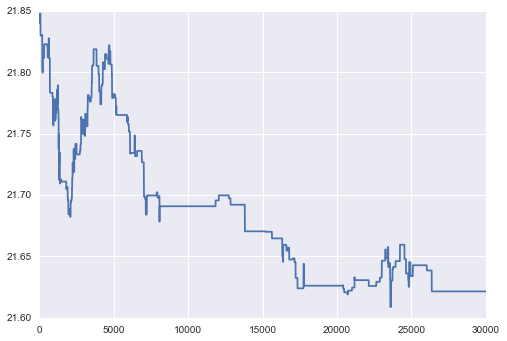

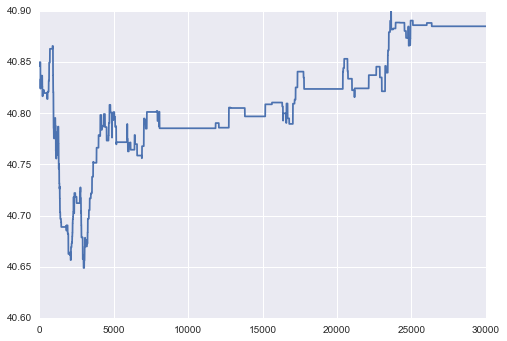

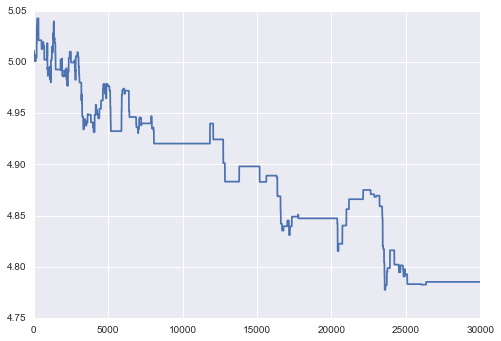

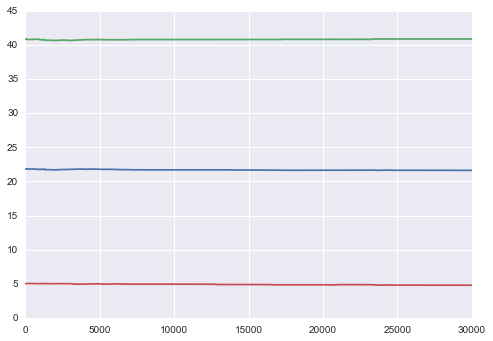

In [63]:
trace = qshift_mu.params.eval()
plt.plot(trace[:,0])
plt.show()
plt.plot(trace[:,1])
plt.show()
plt.plot(trace[:,2])
plt.show()
plt.plot(trace)

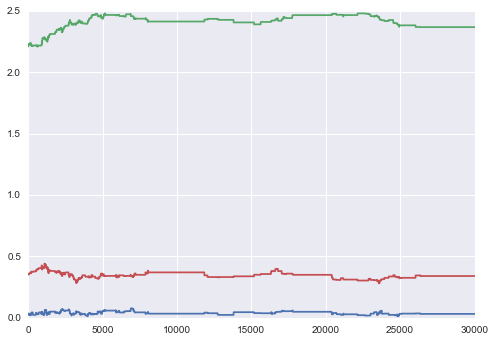

In [64]:
plt.plot(qctrl_mu.params.eval())

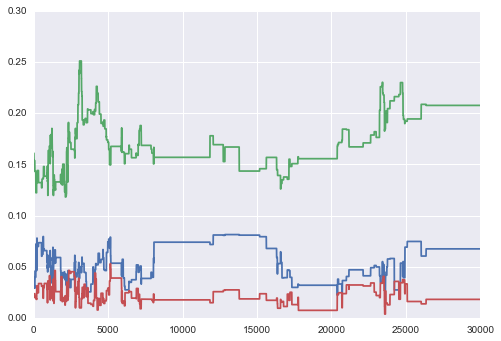

In [65]:
plt.plot(qx_mu.params.eval())

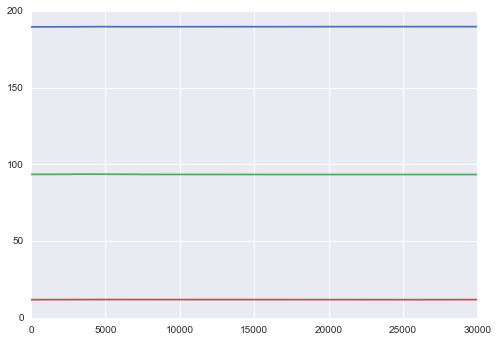

In [67]:
plt.plot(qmove_mu.params.eval())

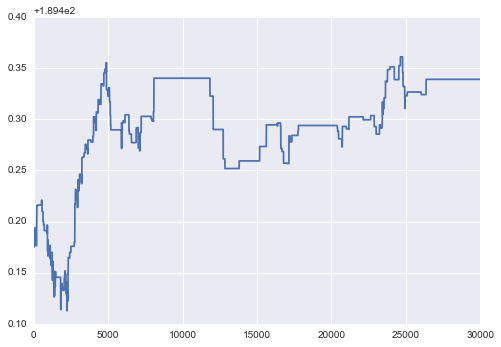

In [69]:
plt.plot(qmove_mu.params.eval()[:,0])

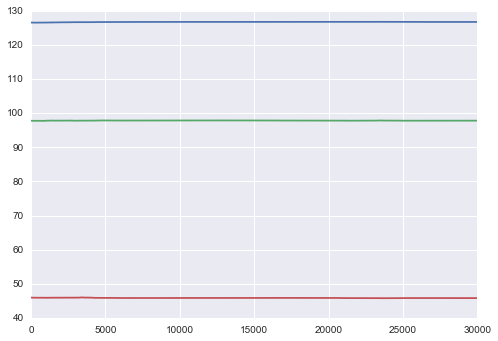

In [68]:
plt.plot(qmove_sd.params.eval())

In [71]:
qdurations.params.shape

TensorShape([Dimension(30000), Dimension(202), Dimension(2)])

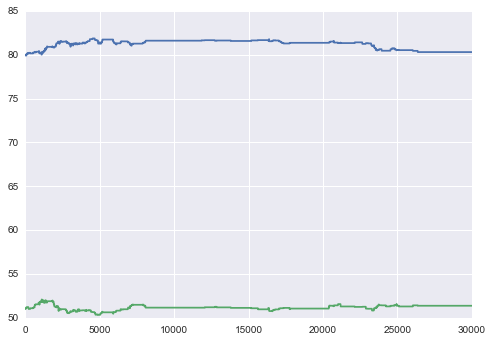

In [72]:
plt.plot(qdurations.params.eval()[:,0,:])

看起来有点变异不够啊，不愧是HM算法的尿性，接下来我本来打算把迭代次数改低试试Gibbs采样和把参数搜索初始点变得更不正常一点看看
能不能产生那种理想的逼近的移动，如果真是一开始就到达了似然性很高的点的话，把proposal分布的方差降低也应该把这些轨迹变得更像“对的”。。
不过现在没电了，只能明天的再试了。

即使这里出现了足够理想的结果并重复此结果到6个stage上（很不幸，因为电脑内存那么小只能分别进行，相当麻烦，
为了减小重复工作又要付出一些额外的工作在整理代码上,还好edward足够给力，不知道比PyMC3高到哪里去了）。
很不幸，这个模型本身就不合理，这里似乎假设时间段那些分布是客观存在的，实际当然不是这样，而为了挖掘隐含策略，我们就必须resort更复杂的隐含模型。
这个虽然在分开的stage上做也是有意义的，但本来在更多stage上联合估计本来可以收集更多信息的。。